In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import minimize
import glob
import os
import sys
import time
from datetime import datetime

from lsst.all_sky_phot.wcs import wcs_zea, wcs_refine_zea, Fisheye, distortion_mapper, distortion_mapper_looper
from lsst.all_sky_phot import phot_night, readcr2, readYBC, radec2altaz, star2altaz, phot_image, default_phot_params

from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, Longitude, Latitude
import astropy.units as u
from astropy.time import Time, TimezoneInfo
from astropy.table import Table, vstack
from astropy import units as u

from photutils import CircularAperture

In [2]:
# read in the file that has manual locations of stars
names = ['star_name', 'x', 'y', 'filename']
types = ['|U10', float, float, '|U30']
rough_positions = np.loadtxt('star_coords.dat', dtype=list(zip(names, types)), skiprows=1)

In [3]:
# figure out what MJD each file was taken at
ufiles, files_inverse = np.unique(rough_positions['filename'], return_inverse=True)
mjds = []
# UT offset for Arizona
utc_offset = 7/24. # in days.
for filename in ufiles:
    hdu1 = fits.open('2018-01-26/'+filename)
    # This says UT, but I think it's AZ time
    date_string = hdu1[0].header['DATE-OBS']
    time_obj = Time(date_string, scale='utc')
    mjds.append(time_obj.mjd+utc_offset)
    hdu1.close()

In [4]:
# grab the location from the header
hdu1 = fits.open('2018-01-26/'+ufiles[0])
lat = Latitude(hdu1[0].header['SITELAT'][:-3], unit=u.deg)
lon = Longitude(hdu1[0].header['SITELONG'][:-3], unit=u.deg)
elevation = 0.728  #km
PI_backyard = EarthLocation(lat=lat, lon=lon, height=elevation*u.km)
hdu1.close()

In [5]:
all_mjds = [mjds[i] for i in files_inverse]
coords = star2altaz(rough_positions['star_name'], all_mjds, location=PI_backyard)

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/units/quantity.py:1000: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return super(Quantity, self).__eq__(other)


In [6]:
coords

array([('Betelgeuse',  58145.14967882,  59.06185724,  139.36200769),
       ('Sirius',  58145.14967882,  32.06618791,  142.99117216),
       ('Procyon',  58145.14967882,  39.45084711,  112.47417639),
       ('Capella',  58145.14967882,  74.21445984,   26.88348425),
       ('Betelgeuse',  58145.3514456 ,  34.89441056,  255.2086305 ),
       ('Rigel',  58145.3514456 ,  17.44987884,  247.94514853),
       ('Sirius',  58145.3514456 ,  27.38767377,  224.63263218),
       ('Procyon',  58145.3514456 ,  52.90860165,  228.72625394),
       ('Polaris',  58145.3514456 ,  32.221987  ,  359.2327691 ),
       ('Mizar',  58145.3514456 ,  43.44211178,   42.85720858),
       ('Regulus',  58145.3514456 ,  67.51123745,  153.07250355),
       ('Mizar',  58145.55447986,  65.34033935,  340.09884902),
       ('Polaris',  58145.55447986,  31.67112342,  359.88925778),
       ('Arcturus',  58145.55447986,  76.7252465 ,  185.39326766),
       ('Regulus',  58145.55447986,  28.96199761,  265.88226211)],
      dtyp

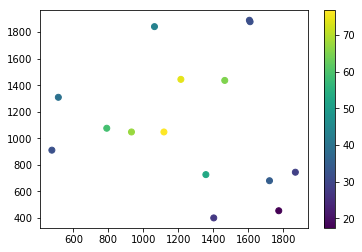

In [7]:
plt.scatter(rough_positions['x'], rough_positions['y'], c=coords['alt'])
cb = plt.colorbar()

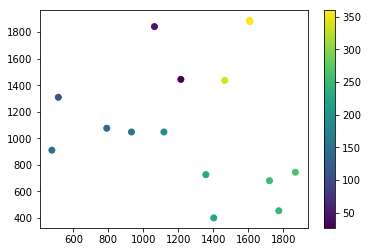

In [8]:
plt.scatter(rough_positions['x'], rough_positions['y'], c=coords['az'])
cb= plt.colorbar()

In [9]:
fun = wcs_zea(rough_positions['x'], rough_positions['y'], coords['alt'], coords['az'],
              crpix1=1202, crpix2=1214)
# Man, figuring out good initial guess for this is a pain in the ass...
x0 = np.array([1200, 1200,  0.5,0.5, 0.1, -0.06,  0.07,   0.1])
fit_result = minimize(fun, x0)

In [10]:
# Convert the fit to a full WCS object
wcs_initial = fun.return_wcs(fit_result.x)

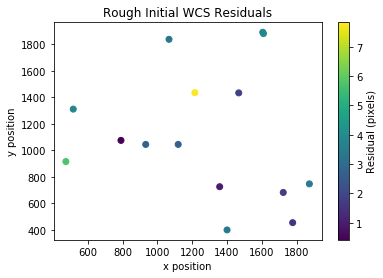

In [11]:
# Check the residuals
fit_x, fit_y = wcs_initial.all_world2pix(coords['az'], coords['alt'], 0)
resid_d = ((fit_x-rough_positions['x'])**2+(fit_y-rough_positions['y'])**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')

In [12]:
# Load the Yale bright star catalog
ybc = readYBC()

In [26]:
# load up a dark time image
filename = '2018-01-26/2018_01_27__04_23_57.fits'
hdul = fits.open(filename)
image = hdul[0].data.copy()
header = hdul[0].header.copy()
hdul.close()

In [17]:
phot_params = default_phot_params()
phot_table = phot_image(image, phot_params=phot_params)

In [30]:
phot_appertures = CircularAperture( (phot_table['xcenter'], phot_table['ycenter']), r=5.)
# guess the camera zeropoint
zp = -18.
measured_mags = -2.5*np.log10(phot_table['residual_aperture_sum'].data) - zp

In [31]:
# Calc where we expect stars
date_string = header['DATE-OBS']
time_obj = Time(date_string, scale='utc')
mjd = time_obj.mjd+utc_offset
alt_cat, az_cat = radec2altaz(ybc['RA'], ybc['Dec'], mjd, location=PI_backyard)
above = np.where(alt_cat > 5.)
x_expected, y_expected = wcs_initial.all_world2pix(az_cat[above], alt_cat[above], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:643: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:643: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:526: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:526: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/pyt

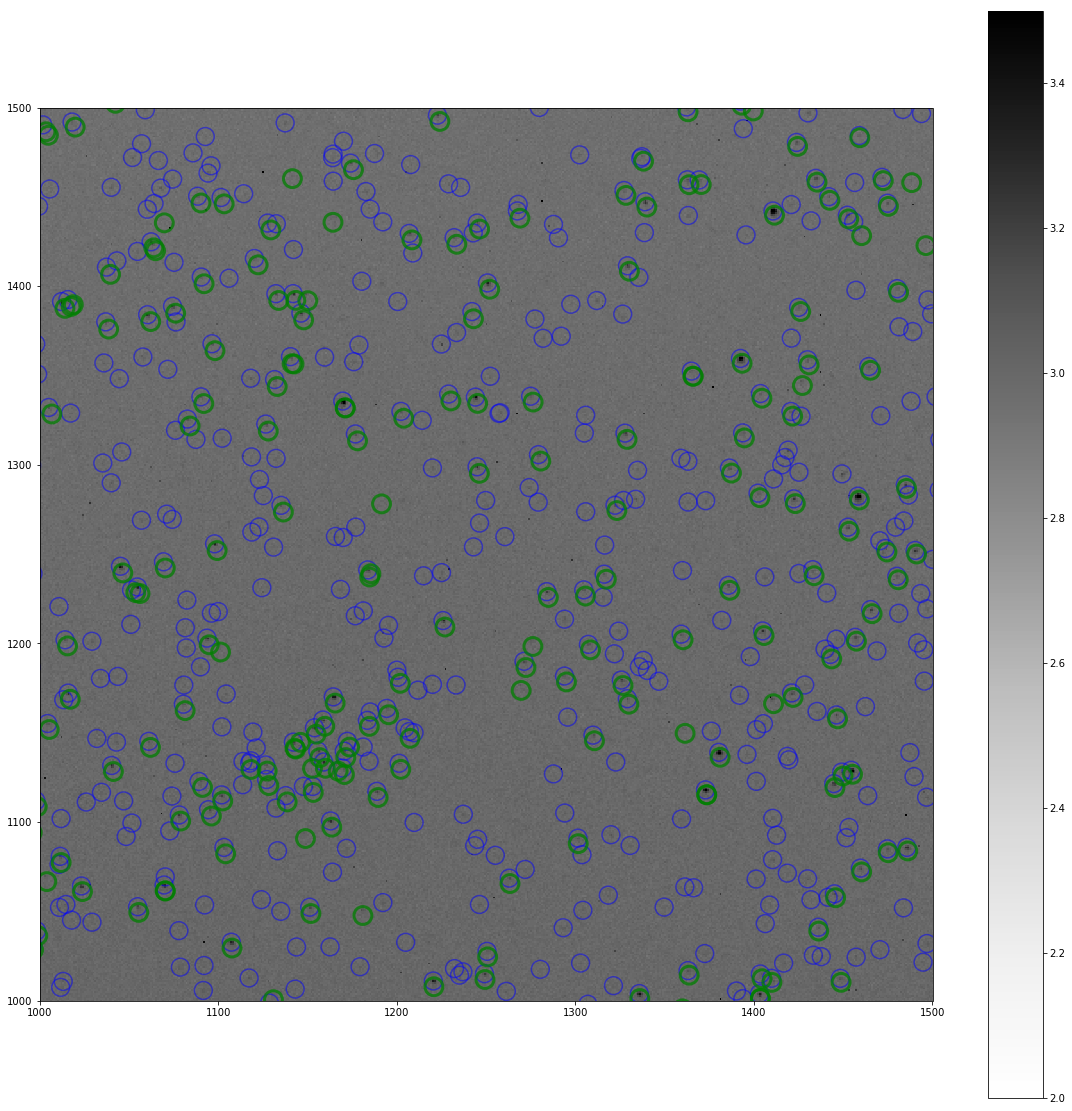

In [36]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=2, vmax=3.5)
plt.colorbar()
plt.xlim([1000, 1500])
plt.ylim([1000, 1500])
# Detected objects in blue
phot_appertures.plot(color='blue', lw=1.5, alpha=0.5)
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.75)